 - zero_gradient Results:
  Subcritical: 100.0%  Supercritical: 0.0%


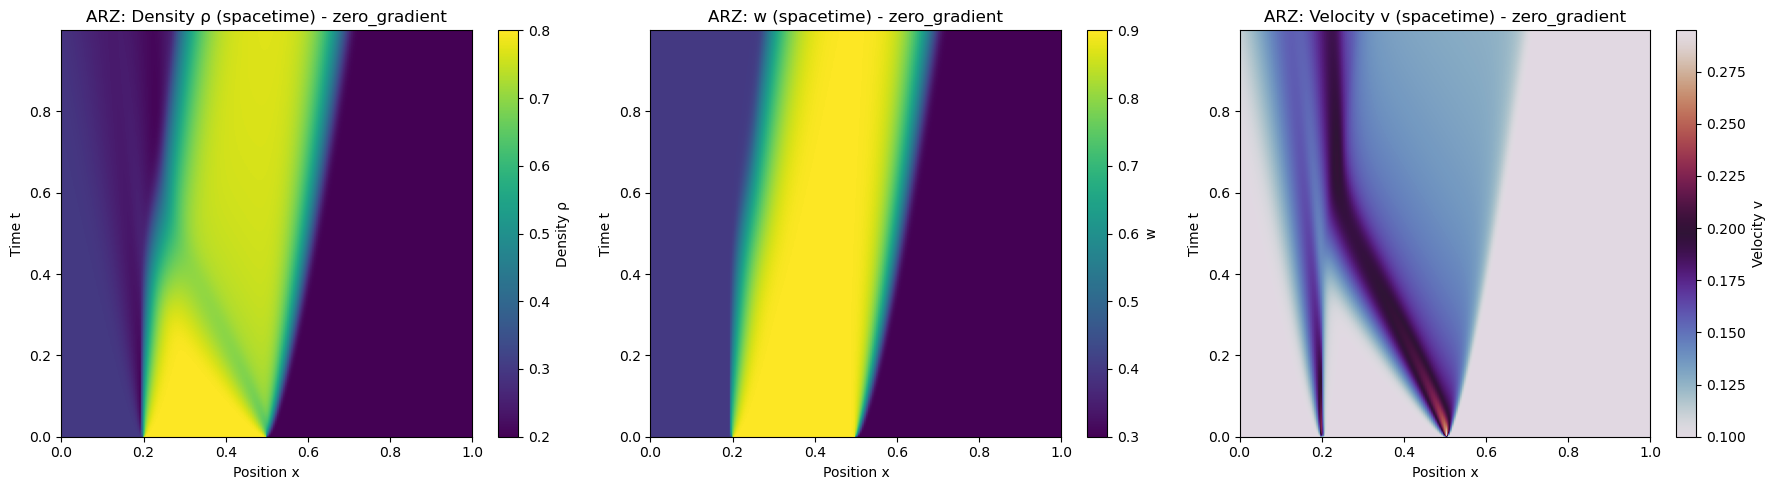

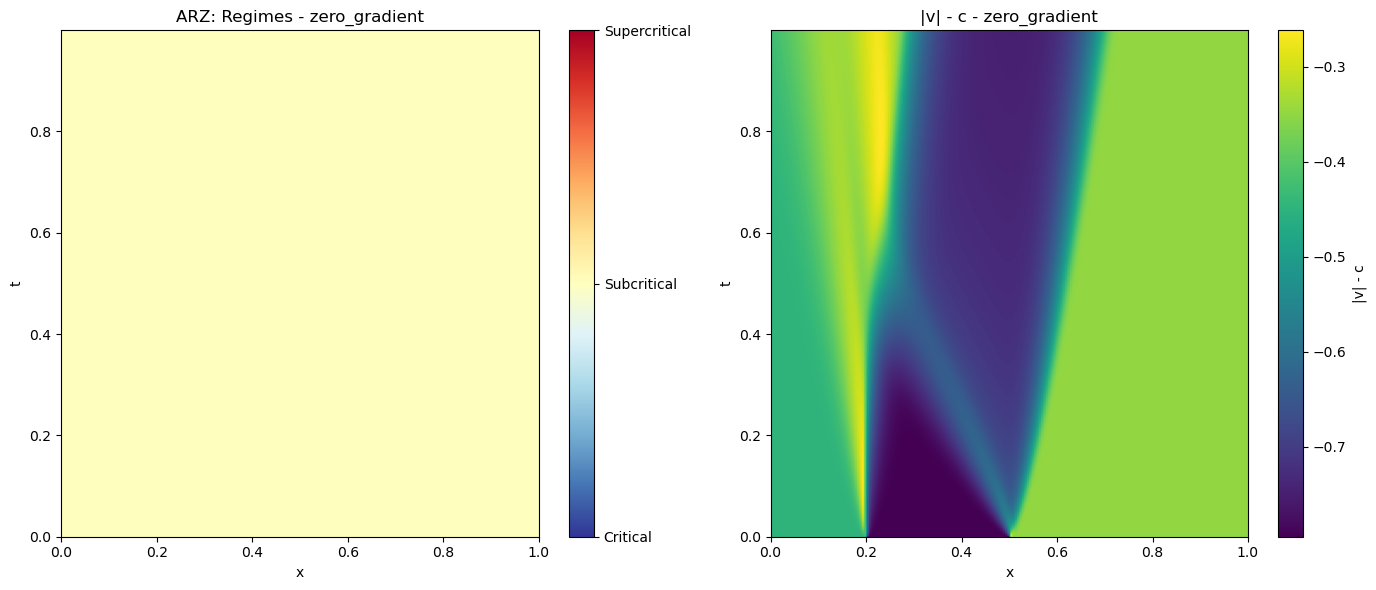

In [ ]:
# Ensure project root is on the path (works whether cwd is project root or notebooks/)
import sys
from pathlib import Path
_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(_root) not in sys.path:
    sys.path.insert(0, str(_root))

from arz_solver import (
    ARZConfig,
    run,
    plot_results,
    initial_condition_riemann,
    initial_condition_from_steps,
)

# --- Configuration: change these to change the run ---
config = ARZConfig(nx=200, L=1.0, T=1.0, gamma=1.0)

rho0, w0 = initial_condition_from_steps(
    config.x,
    rho_steps=[(0.2, 0.3), (0.5, 0.8), (1.0, 0.2)]
)

# Solve with zero-gradient BC and plot
rho_history, w_history, v_history = run(rho0, w0, config, bc_type="zero_gradient")
plot_results(rho_history, w_history, v_history, config, title_suffix=" - zero_gradient")



Testing: zero_gradient
 - zero_gradient Results:
  Subcritical: 100.0%  Supercritical: 0.0%


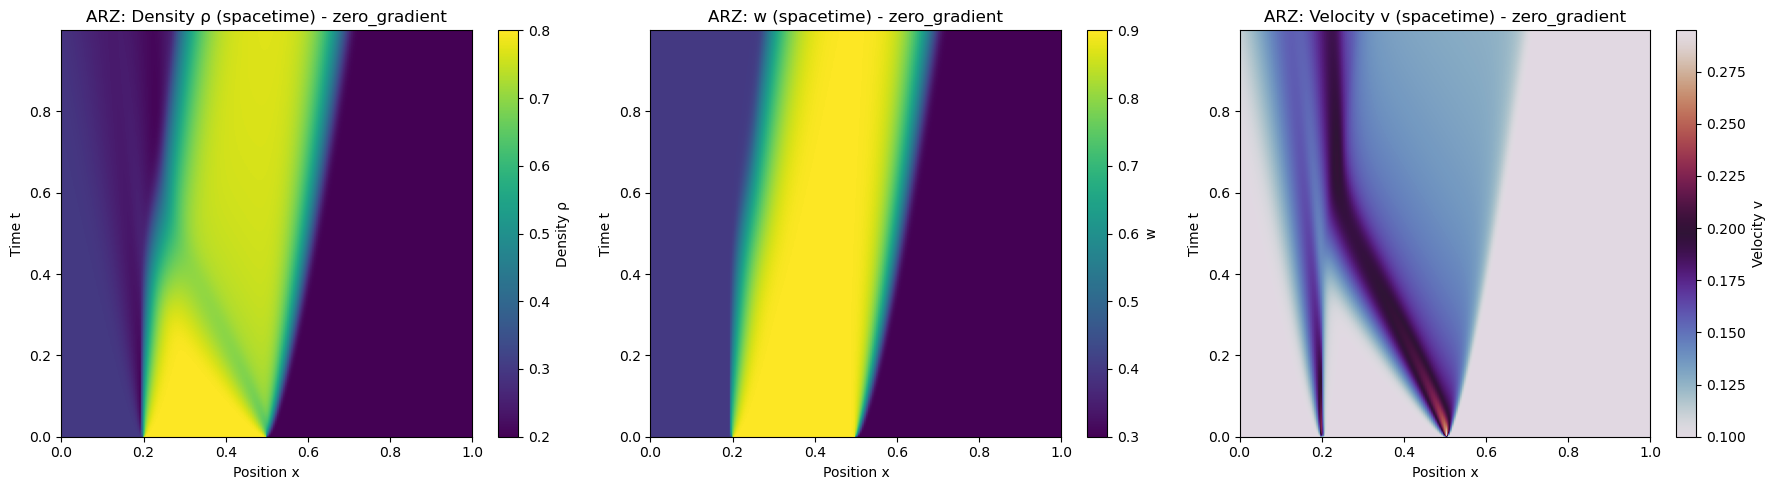

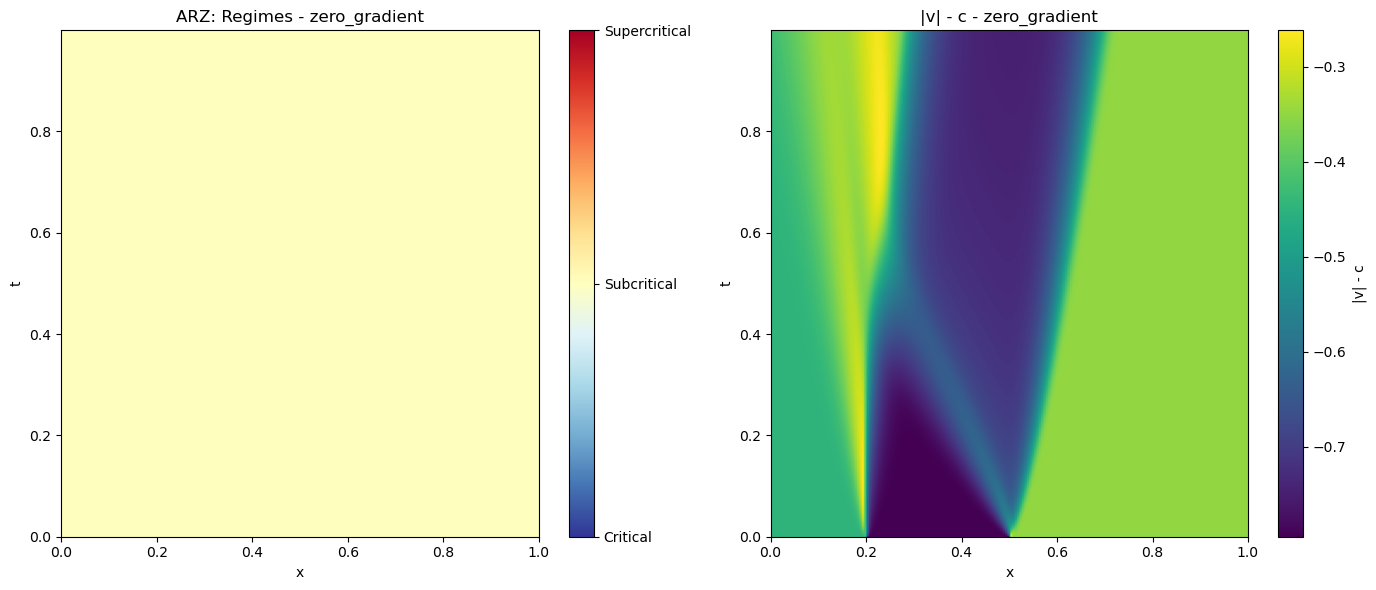

In [12]:
# Run with different boundary conditions (uses same config and IC as cell above)
BC_TYPES = ["zero_gradient", "periodic", "inflow_outflow", "time_varying_inflow", "dirichlet"]

# Uncomment to run all; or set to a single BC, e.g. ["periodic"]
bc_types_to_run = ["zero_gradient"]

for bc_type in bc_types_to_run:
    print(f"\n{'='*60}\nTesting: {bc_type}\n{'='*60}")
    rho_hist, w_hist, v_hist = run(rho0, w0, config, bc_type=bc_type)
    plot_results(rho_hist, w_hist, v_hist, config, title_suffix=f" - {bc_type}")

